In [6]:
import numpy as np
import scipy.optimize as sopt
import matplotlib.pyplot as plt
import pydae.ssa as ssa
import pydae.grid_tools as gt
from pydae.tools import get_i
import json
import time
import scipy.optimize as sopt
import pandas as pd
from scipy.sparse.linalg import spsolve,spilu,splu
import matplotlib.pyplot as plt
from pydae.svg_tools import svg,grid2svg
from IPython.core.display import HTML,SVG


In [7]:
def get_bus_powers(gt_grid,bus_name):
    idx = gt_grid.bus_data['bus_id'].index(bus_name)
    p_a,q_a = gt_grid.buses[idx]['p_a'],gt_grid.buses[idx]['p_a']
    p_b,q_b = gt_grid.buses[idx]['p_b'],gt_grid.buses[idx]['q_b']
    p_c,q_c = gt_grid.buses[idx]['p_c'],gt_grid.buses[idx]['q_c']
    p = p_a + p_b + p_c
    q = q_a + q_b + q_c
    return p,q

def set_buses_voltages(self):

    v_ac_min = 20e6
    min_dc_voltage = 20e6
    min_n_ac_voltage = 20e6
    min_n_dc_voltage = 20e6    

    v_ac_max = 0
    max_dc_voltage = 0
    max_n_ac_voltage = 0
    max_n_dc_voltage = 0  


    for bus in self.grid_data['buses']:
        v_r = self.grid.get_value(f'v_{bus["bus"]}_a_r') 
        v_i = self.grid.get_value(f'v_{bus["bus"]}_a_i') 
        v = v_r + 1j*v_i
        v_abs = np.abs(v)
        V_med_pu= 0.5*(self.V_max_pu + self.V_min_pu)
        acdc = 'ac'
        if 'acdc' in bus:
            if bus['acdc'] == 'DC':
                V_nom = bus['U_kV']*1000
                acdc = 'dc'
            if bus['acdc'] == 'AC':
                V_nom = bus['U_kV']/np.sqrt(3)*1000  
                acdc = 'ac'
        else:
            V_nom = bus['U_kV']/np.sqrt(3)*1000 
            acdc = 'ac'

        V_pu = v_abs/V_nom

        # when V_pu = V_med_pu color = 0, when V_pu = V_max_pu color = 255 (red)
        # when V_pu = V_med_pu color = 0, when V_pu = V_min_pu color = 255 (blue)
        if V_pu < V_med_pu:
            blue = np.clip(255*((V_pu - V_med_pu)/(self.V_min_pu - V_med_pu))**2,0,255)
            self.set_color('rect',f'{bus["bus"]}',(0,0,int(blue)))  
        if V_pu > V_med_pu:
            red  = np.clip(255*((V_pu - V_med_pu)/(self.V_max_pu - V_med_pu))**2,0,255)
            self.set_color('rect',f'{bus["bus"]}',(int(red),0,0)) 

        if acdc == 'ac':
            if V_pu < v_ac_min:
                self.post_data.update({'v_ac_min':{'bus':bus['bus'],'value':V_pu}})
                v_ac_min = V_pu
            if V_pu > v_ac_max:
                self.post_data.update({'v_ac_max':{'bus':bus['bus'],'value':V_pu}})
                v_ac_max = V_pu  

In [8]:
from cigre_eu_lv_acdc import cigre_eu_lv_acdc_class

In [9]:
import pandas as pd

case = 'Case 2'

df_loads_ac = pd.read_excel('cigre_lv.xlsx', 
              sheet_name=case, 
              header=1, names=None, index_col=0, 
              usecols=[1,4,5], 
              skiprows=[8,9,10,12,13,14,23,24,25,26])

df_loads_dc = pd.read_excel('cigre_lv.xlsx', 
              sheet_name=case, 
              header=1, names=None, index_col=0, 
              usecols=[7,8,10], 
              skiprows=[2,8,9,10,12,13,14,15,17,18,20,21,23,24,25,26])

df_loads_ac

,P (kW),Q (kvar)
Bus,,
R01,190.00,62.449980
R11,14.25,4.683748
R15,49.40,16.236995
R16,52.25,17.173744
R17,33.25,10.928746
R18,44.65,14.675745
I02,85.00,52.678269
C01,108.00,52.306787
C12,18.00,8.717798


In [11]:
grid = cigre_eu_lv_acdc_class()

lf = 1.0
K_dc = 5/100e3
params = {'v_dc_S01':800,'v_dc_H01':800,'v_dc_D01':800,
          'K_dc_S01':K_dc,'K_dc_H01':K_dc,'K_dc_D01':K_dc,
         'p_vsc_R10':100e3,
         'p_vsc_C09':100e3}

for item in df_loads_ac.index:
    p_kw   = df_loads_ac.loc[item]['P (kW)']
    q_kvar = df_loads_ac.loc[item]['Q (kvar)']

    for ph in ['a','b','c']:
        params.update({f'p_load_{item}_{ph}':1e3*p_kw/3})
        params.update({f'q_load_{item}_{ph}':1e3*q_kvar/3})
        
for item in df_loads_dc.index:
    p_kw   = df_loads_dc.loc[item]['Pdc (kW)']

    for ph in ['a']:
        params.update({f'p_load_{item}_{ph}':1e3*p_kw})
        params.update({f'q_load_{item}_{ph}':0.0})
    for ph in ['b','c']:
        params.update({f'p_load_{item}_{ph}':0.0})
        params.update({f'q_load_{item}_{ph}':0.0})
        
        
#grid_c0.load_0()
t_0 = time.time()
grid.ini(params,'xy_0_dict.json')
print(time.time()-t_0)
#grid.report_y()
grid.fill_factor_ini = 100
grid.drop_tol_ini = 1e-10
grid.drop_rule_ini = 'basic,dynamic,area,prows'
grid.eval_preconditioner_ini()
#grid.spini(params,'xy_0.json')
gt.report_v(grid,'cigre_eu_lv_acdc.json')

LinAlgError: Matrix is singular to machine precision.

In [102]:
N = grid.jac_ini.shape[0]
np.linalg.cond(grid.jac_ini)/1e6

0.2055384382662584

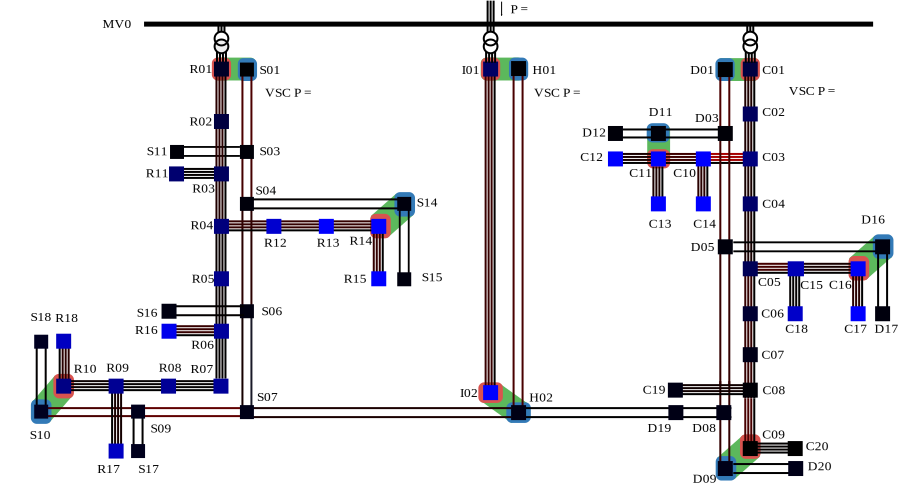

In [103]:
s = svg('cigre_eu_lv_acdc_v2.svg')

s.set_grid(grid,'cigre_eu_lv_acdc.json')


for bus in s.grid_data['buses']:
    bus_id = bus['bus']
    bus_elm_list = s.root.findall(f".//*[@id='{bus_id}']")
    if len(bus_elm_list) > 0:
        bus_elm = bus_elm_list[0]
    else:
        print(f'SVG element {bus_id} not found')
        continue

    if f"v_{bus['bus']}_n_r" in grid.y_ini_list:
        v_n_r,v_n_i = grid.get_mvalue([f"v_{bus['bus']}_n_r",f"v_{bus['bus']}_n_i"])
        v_n = v_n_r + 1j*v_n_i
    else:
        v_n = 0.0
    for ph,da in zip(['a','b','c'],['data1','data2','data3']):
        v_r,v_i =  grid.get_mvalue([f"v_{bus['bus']}_{ph}_r",f"v_{bus['bus']}_{ph}_i"])
        v = v_r + 1j*v_i
        v_m = np.abs(v-v_n)
        if 'acdc' in bus:
            v_base = bus['U_kV']*1000
        else:
            v_base = bus['U_kV']*1000/np.sqrt(3)
        bus_elm.attrib[da] =f"{v_m:20.1f} V / {v_m/v_base:9.2f} pu "
    bus_elm.attrib['data4'] =f"{np.abs(v_n):20.1f} V"   
    bus_elm.attrib['data0'] = 'bus'

    p_load_a,q_load_a = -0.001,-0.001
    p_load_b,q_load_b = -0.001,-0.001
    p_load_c,q_load_c = -0.001,-0.001
    if f"p_load_{bus_id}_a" in grid.u_ini_list:
        p_load_a = grid.get_value(f"p_load_{bus_id}_a")
        q_load_a = grid.get_value(f"q_load_{bus_id}_a")
        p_load_b = grid.get_value(f"p_load_{bus_id}_b")
        q_load_b = grid.get_value(f"q_load_{bus_id}_b")
        p_load_c = grid.get_value(f"p_load_{bus_id}_c")
        q_load_c = grid.get_value(f"q_load_{bus_id}_c")
    p_load = p_load_a + p_load_b + p_load_c
    q_load = q_load_a + q_load_b + q_load_c

    bus_elm.attrib['data5'] =f"{p_load/1e3:20.1f} kW" 
    bus_elm.attrib['data6'] =f"{q_load/1e3:20.1f} kvar" 
    bus_elm.attrib['data7'] =f"xx" 
        
    bus_elm.attrib['class'] = 'tooltip-trigger'

for line in s.grid_data['lines']:
    bus_j = line['bus_j']
    bus_k = line['bus_k']

    for ph in ['a','b','c','n']:
                     
        line_id = f'l_{bus_j}_{bus_k}_{ph}'
        line_svg =  s.root.findall(f".//*[@id='{line_id}']")
        if len(line_svg)>0:
            line_elm = line_svg[0]
        else:
            continue
        line_elm.attrib['data0'] = 'line'

        for phi,da in zip(['a','b','c','n'],['data1','data2','data3','data4']):
            meas_line_id = f'l_{bus_j}_{bus_k}_{phi}'

            i_m = 0.0
            if f'i_{line_id}_r' in grid.outputs_list:
                i_r,i_i =  grid.get_mvalue([f"i_{meas_line_id}_r",f"i_{meas_line_id}_i"])
                i = i_r + 1j*i_i
                i_m = np.abs(i)      
            v_base = 1.0
            line_elm.attrib[da] =f"{i_m:20.1f} A / {i_m/v_base:9.2f} pu "

        line_elm.attrib['class'] = 'tooltip-trigger'

for trafo in s.grid_data['transformers']:
    bus_j = trafo['bus_j']
    bus_k = trafo['bus_k']
    
    for wind in [1,2]:
        trafo_id = f'trafo_{bus_j}_{bus_k}_{wind}'

        trafo_svg =  s.root.findall(f".//*[@id='{trafo_id}']")
        if len(trafo_svg)>0:
            trafo_elm = trafo_svg[0]
        else:
            print(f'No trafo {trafo_id} found')
            continue

        trafo_elm.attrib['data0'] = 'trafo'
        
        string_1 = ''
        for ph in ['a','b','c']:
            i_r,i_i =  grid.get_mvalue([f'i_t_{bus_j}_{bus_k}_1_{ph}_r',f'i_t_{bus_j}_{bus_k}_1_{ph}_i'])
            i = i_r + 1j*i_i
            i_m = np.abs(i)  
            string_1 += f'{ph}:  {i_m:0.2f}\t'

        string_2 = ''
        for ph in ['a','b','c','n']:
            i_r,i_i =  grid.get_mvalue([f'i_t_{bus_j}_{bus_k}_2_{ph}_r',f'i_t_{bus_j}_{bus_k}_2_{ph}_i'])
            i = i_r + 1j*i_i
            i_m = np.abs(i)  
            string_2 += f'{ph}: {i_m:0.2f}     '
            
        trafo_elm.attrib['data1'] = string_1 + ' A'
        trafo_elm.attrib['data2'] = string_2 + ' A'
        trafo_elm.attrib['data3'] = 'trafo'
        trafo_elm.attrib['data4'] = 'trafo'
    trafo_elm.attrib['class'] = 'tooltip-trigger'
    
for vsc in s.grid_data['vscs']:
    bus_ac = vsc['bus_ac']
    bus_dc = vsc['bus_dc']
    vsc_id = f'vsc_{bus_ac}_{bus_dc}'
    
    vsc_svg =  s.root.findall(f".//*[@id='{vsc_id}']")
    if len(vsc_svg)>0:
        vsc_elm = vsc_svg[0]
    else:
        print(f'No VSC {vsc_id} found')
        continue
    vsc_elm.attrib['data0'] = 'vsc'
    p_dc = grid.get_value(f'p_vsc_{bus_dc}')
    vsc_elm.attrib['data1'] = f'VSC'

    p_ac = grid.get_value(f'p_vsc_{bus_ac}')   
    p_dc = grid.get_value(f'p_vsc_{bus_dc}')   
    vsc_elm.attrib['data2'] = f'  Pac = {p_ac/1e3:0.1f} kW,  Pdc = {p_dc/1e3:0.1f} kW'
    
    p_loss = grid.get_value(f'p_vsc_loss_{bus_ac}')
    vsc_elm.attrib['data3'] = f'  Losses = {p_loss/1e3:0.1f} kW'
    


    vsc_elm.attrib['class'] = 'tooltip-trigger'
        
script = '''
<![CDATA[
		(function() {
			var svg = document.getElementById('cigre_eu_lv_acdc');
			var tooltip_1 = svg.getElementById('tooltip1');
        var tooltipText_1_1 = tooltip_1.getElementsByTagName('text')[0];
        var tooltipText_1_2 = tooltip_1.getElementsByTagName('text')[1];
        var tooltipText_1_3 = tooltip_1.getElementsByTagName('text')[2];
        var tooltipText_1_4 = tooltip_1.getElementsByTagName('text')[3];
        var tooltipText_1_5 = tooltip_1.getElementsByTagName('text')[4];
        var tooltipText_1_6 = tooltip_1.getElementsByTagName('text')[5];
			var tooltip_2 = svg.getElementById('tooltip2');
        var tooltipText_2_1 = tooltip_2.getElementsByTagName('text')[0];
        var tooltipText_2_2 = tooltip_2.getElementsByTagName('text')[1];
        var tooltipText_2_3 = tooltip_2.getElementsByTagName('text')[2];
        var tooltipText_2_4 = tooltip_2.getElementsByTagName('text')[3];
        var tooltipText_2_5 = tooltip_2.getElementsByTagName('text')[4];
        var tooltipText_2_6 = tooltip_2.getElementsByTagName('text')[5];
			var tooltip_3 = svg.getElementById('tooltip3');
        var tooltipText_3_1 = tooltip_3.getElementsByTagName('text')[0];
        var tooltipText_3_2 = tooltip_3.getElementsByTagName('text')[1];
        var tooltipText_3_3 = tooltip_3.getElementsByTagName('text')[2];
        var tooltipText_3_4 = tooltip_3.getElementsByTagName('text')[3];

        var tooltipRects = tooltip_1.getElementsByTagName('rect');
        var triggers = svg.getElementsByClassName('tooltip-trigger');
        for (var i = 0; i < triggers.length; i++) {
            triggers[i].addEventListener('mousemove', showTooltip);
            triggers[i].addEventListener('mouseout', hideTooltip);
        }
        function showTooltip(evt) {
            var CTM = svg.getScreenCTM();
            var x_unsat =  (evt.clientX - CTM.e) / CTM.a
            var x = x_unsat;
            if  (x_unsat>x_max) {var x = x_max}
            if  (x_unsat<x_min) {var x = x_min}

           
            var y_unsat = (evt.clientY - CTM.f) / CTM.d + 30;
            var y = y_unsat;
            if  (y_unsat>y_max) {var y = y_max - y_height}
           
            
            if (evt.target.getAttributeNS(null, "data0") == "bus") {
                tooltip_1.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                tooltip_1.setAttributeNS(null, "visibility", "visible")}
            
            if (evt.target.getAttributeNS(null, "data0") == "line") {
                tooltip_2.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                tooltip_2.setAttributeNS(null, "visibility", "visible")}

            if (evt.target.getAttributeNS(null, "data0") == "vsc") {
                tooltip_3.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                tooltip_3.setAttributeNS(null, "visibility", "visible")}
                
            if (evt.target.getAttributeNS(null, "data0") == "trafo") {
                tooltip_3.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                tooltip_3.setAttributeNS(null, "visibility", "visible")}    
                
            tooltipText_1_1.firstChild.data = evt.target.getAttributeNS(null, "data1");
            tooltipText_1_2.firstChild.data = evt.target.getAttributeNS(null, "data2");
            tooltipText_1_3.firstChild.data = evt.target.getAttributeNS(null, "data3");
            tooltipText_1_4.firstChild.data = evt.target.getAttributeNS(null, "data4");
            tooltipText_1_5.firstChild.data = evt.target.getAttributeNS(null, "data5");
            tooltipText_1_6.firstChild.data = evt.target.getAttributeNS(null, "data6");
 
            tooltipText_2_1.firstChild.data = evt.target.getAttributeNS(null, "data1");
            tooltipText_2_2.firstChild.data = evt.target.getAttributeNS(null, "data2");
            tooltipText_2_3.firstChild.data = evt.target.getAttributeNS(null, "data3");
            tooltipText_2_4.firstChild.data = evt.target.getAttributeNS(null, "data4");
            tooltipText_2_5.firstChild.data = evt.target.getAttributeNS(null, "data5");
            tooltipText_2_6.firstChild.data = evt.target.getAttributeNS(null, "data6");

            tooltipText_3_1.firstChild.data = evt.target.getAttributeNS(null, "data1");
            tooltipText_3_2.firstChild.data = evt.target.getAttributeNS(null, "data2");
            tooltipText_3_3.firstChild.data = evt.target.getAttributeNS(null, "data3");
            tooltipText_3_4.firstChild.data = evt.target.getAttributeNS(null, "data4");
            
				var length = tooltipText_1_1.getComputedTextLength()+200;
				for (var i = 0; i < tooltipRects.length; i++) {
					tooltipRects[i].setAttributeNS(null, "width", length + 8);
				}
			}
			function hideTooltip(evt) {
				tooltip_1.setAttributeNS(null, "visibility", "hidden");
				tooltip_2.setAttributeNS(null, "visibility", "hidden");
				tooltip_3.setAttributeNS(null, "visibility", "hidden");
			}
		})()
    ]]>'''

from xml.etree.ElementTree import Element

element = Element('script')
element.attrib['type'] ="text/ecmascript"
element.attrib['id'] = "script15"
element.text = 'scriptplace'
s.root.append(element)

s.set_lines_currents()
set_buses_voltages(s)
    
out = s.tostring().replace('scriptplace',script)
width = float(s.root.attrib['width'])
height = float(s.root.attrib['height'])

tooltip_width = 320
tooltip_height = 100

out=out.replace('x_max',f'{width-tooltip_width/2}' )
out=out.replace('x_min',f'{tooltip_width/2}' )
out=out.replace('y_max',f'{height-tooltip_height}' )
out=out.replace('y_height',f'{tooltip_height}' )

with open('out.svg','w') as fobj:
    fobj.write(out)
    
SVG('out.svg')

In [104]:
grid.report_u()

v_MV0_a_r =11547.00
v_MV0_a_i = 0.00
v_MV0_b_r =-5773.50
v_MV0_b_i =-10000.00
v_MV0_c_r =-5773.50
v_MV0_c_i =10000.00
v_S01_a_i = 0.00
v_S01_b_r = 0.00
v_S01_b_i =-0.00
v_S01_c_r =-0.00
v_S01_c_i = 0.00
v_H01_a_i = 0.00
v_H01_b_r = 0.00
v_H01_b_i =-0.00
v_H01_c_r =-0.00
v_H01_c_i = 0.00
v_D01_a_i = 0.00
v_D01_b_r = 0.00
v_D01_b_i =-0.00
v_D01_c_r =-0.00
v_D01_c_i = 0.00
i_R01_a_r =-0.00
i_R01_a_i = 0.00
i_R01_b_r = 0.00
i_R01_b_i = 0.00
i_R01_c_r =-0.00
i_R01_c_i =-0.00
i_R01_n_r =-0.00
i_R01_n_i =-0.00
i_R11_a_r =-0.00
i_R11_a_i = 0.00
i_R11_b_r = 0.00
i_R11_b_i = 0.00
i_R11_c_r =-0.00
i_R11_c_i =-0.00
i_R11_n_r = 0.00
i_R11_n_i =-0.00
i_R15_a_r =-0.00
i_R15_a_i = 0.00
i_R15_b_r = 0.00
i_R15_b_i = 0.00
i_R15_c_r =-0.00
i_R15_c_i =-0.00
i_R15_n_r = 0.00
i_R15_n_i =-0.00
i_R16_a_r =-0.00
i_R16_a_i = 0.00
i_R16_b_r = 0.00
i_R16_b_i = 0.00
i_R16_c_r =-0.00
i_R16_c_i =-0.00
i_R16_n_r = 0.00
i_R16_n_i =-0.00
i_R17_a_r =-0.00
i_R17_a_i = 0.00
i_R17_b_r = 0.00
i_R17_b_i = 0.00
i_R17_c_r =-0.0

In [105]:
grid.fill_factor_ini = 100
grid.drop_tol_ini = 1e-8
grid.drop_rule_ini = 'basic,dynamic,area,prows'
grid.eval_preconditioner_ini()
grid.ltol_ini =1e-6
N = grid.P_slu.shape[0]
Nnz = grid.P_slu.nnz
print(f'{N**2}, {Nnz}, {Nnz/N**2*100}')


700569, 17115, 2.4430141784749253


In [106]:
N_ini = grid.jac_ini.shape[0]
N_ini**2

700569

In [107]:
N_ini = grid.jac_ini.shape[0]
N_J_ini = N_ini**2

Nnz_J_ini_num = 12265-3920
Nnz_J_ini_xy = 3906 - 2924 - 33
Nnz_J_ini_up = 3
Nnz_J_ini = Nnz_J_ini_num+Nnz_J_ini_xy+Nnz_J_ini_up
print(f'N_J_ini = {N_J_ini}, Nnnz = {Nnz_J_ini}, Nnnz% = {100*Nnz_J_ini/N_J_ini:0.1f} (%), Nnnz xyn(%) = {100*Nnz_J_ini_xy/N_J_ini:0.2f}%' )
grid.sp_jac_ini


N_J_ini = 700569, Nnnz = 9297, Nnnz% = 1.3 (%), Nnnz xyn(%) = 0.14%


<837x837 sparse matrix of type '<class 'numpy.float64'>'
	with 9826 stored elements in Compressed Sparse Row format>

In [108]:
N_J_ini

700569

In [109]:
len(grid.jac_ini[grid.jac_ini==0])

690895

In [110]:
t_0 = time.time()
i_list = []
N = 100
p_vsc_R10s = np.linspace(0,100e3,N) #(0.5-np.random.rand(N))*10e3+8e3
for p_vsc_R10 in p_vsc_R10s:
    grid.spini({'p_vsc_R10':p_vsc_R10})
    i_list += [grid.get_value('i_t_MV0_C01_a_r')]
print(f'Total time: {time.time()-t_0:0.2f} s, Time per loop: {(time.time()-t_0)/N*1000:0.1f} ms' )

Total time: 7.26 s, Time per loop: 72.6 ms


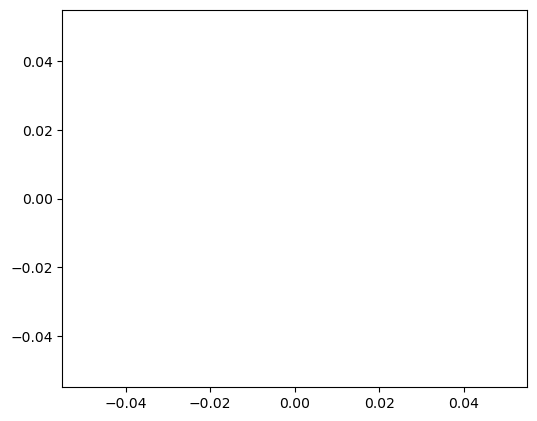

In [111]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 5), dpi=100)
axes.plot(p_vsc_R10s,i_list,'.')

In [112]:
import ipywidgets as widgets
grid = cigre_eu_lv_acdc_class()

sld_p_vsc = widgets.FloatSlider(orientation='horizontal',description = "p (kW)", 
                                value=0, min=-120,max= 120,step=5,continuous_update=False)
sld_q_vsc = widgets.FloatSlider(orientation='horizontal',description = "q (kvar)", 
                                value=0, min=-120,max= 120,step=5,continuous_update=False)


vsc_dict = {'VSC R10-S10':{'p':'p_vsc_R10','q':'q_vsc_R10'},
            'VSC R14-S14':{'p':'p_vsc_R14','q':'q_vsc_R14'},
            'VSC I02-H02':{'p':'p_vsc_I02','q':'q_vsc_I02'},
            'VSC C09-D09':{'p':'p_vsc_C09','q':'q_vsc_C09'},
            'VSC C11-D11':{'p':'p_vsc_C11','q':'q_vsc_C11'},
            'VSC C16-D16':{'p':'p_vsc_C16','q':'q_vsc_C16'},
            }        
        
sel_vsc = widgets.Select(
    options=[item for item in vsc_dict],
    value='VSC R10-S10',
    # rows=10,
    description='VSC:',
    disabled=False
)

text_post = widgets.Textarea(
    value='Hello \nWorld',
    placeholder='Type something',
    description='',
    disabled=False
)

set_v(grid,'MV0',20e3*1.025) 

#params.update(params_loads)
grid.ini(params,xy_0='xy_0.json')


grid.fill_factor_ini = 100
grid.drop_tol_ini = 1e-10
grid.drop_rule_ini = 'basic'
grid.eval_preconditioner_ini()
grid.ltol_ini =1e-8

svg_1 = svg('out.svg')
svg_1.set_grid(grid,'cigre_eu_lv_acdc.json')
svg_1.V_min_pu = 0.95   
svg_1.V_max_pu = 1.05    
svg_1.post_data = {}

html_grid = widgets.HTML(svg_1.tostring())

def update(change):
    #options=['VSC R10-S10','VSC R14-S14','VSC I02-H02','VSC C16-D16','VSC C09-D09'],
    
    grid.set_value(vsc_dict[sel_vsc.value]['p'],1000*sld_p_vsc.value)
    grid.set_value(vsc_dict[sel_vsc.value]['q'],1000*sld_q_vsc.value)
    
    grid.spini({})
    #gt_grid = gt.grid(grid)
    #grid.report_u()

    svg_1.set_text('VSC_R01_S01_P',f"{grid.get_value('p_vsc_S01')/1000:2.0f} kW")
    svg_1.set_text('VSC_I01_H01_P',f"{grid.get_value('p_vsc_H01')/1000:2.0f} kW")
    svg_1.set_text('VSC_C01_D01_P',f"{grid.get_value('p_vsc_D01')/1000:2.0f} kW")

    svg_1.set_lines_currents()
    set_buses_voltages(svg_1)
    
    s_total = get_powers(grid)
    
    post_text = f"V min/max {svg_1.post_data['v_ac_min']['bus']}: {svg_1.post_data['v_ac_min']['value']:0.2f}, "
    post_text+= f"{svg_1.post_data['v_ac_max']['bus']}: {svg_1.post_data['v_ac_max']['value']:0.2f}\n"
    post_text+= f"P = {s_total.real/1e3:0.1f} kW"
    text_post.value = post_text
    
    html_grid.value = svg_1.tostring()
    
    
def update_select(change):
    #options=['VSC R10-S10','VSC R14-S14','VSC I02-H02','VSC C16-D16','VSC C09-D09'],
    sld_p_vsc.value = grid.get_value(vsc_dict[sel_vsc.value]['p'])/1000
    sld_q_vsc.value = grid.get_value(vsc_dict[sel_vsc.value]['q'])/1000
    
    
update(0)

sld_p_vsc.observe(update, names='value')
sld_q_vsc.observe(update, names='value')

sel_vsc.observe(update_select, names='value')

layout_row1 = widgets.HBox([html_grid])
layout_row2 = widgets.HBox([sel_vsc,widgets.VBox([sld_p_vsc,sld_q_vsc]),text_post])
#layout_row3 = widgets.HBox([sld_q_vsc_R10])

layout = widgets.VBox([layout_row1,layout_row2])
layout

NameError: name 'set_v' is not defined

In [9]:
import numpy as np

P_0 = 1600
R_cc = 0.002
I_2_n = 909.32
C = 0.4
P_j = 3*R_cc*(I_2_n*C)**2
P_j
P_2 = I_2_n*C*400*np.sqrt(3)*0.8
rend = P_2/(P_2 + P_j + P_0)
rend*100
P_j

793.7883479040003

In [13]:
V_1 = 20150/np.sqrt(3)
Z_cc = 6 + 1j*37
S_2 = (403.2 + 1j*302.4)*1000

V_2 = V_1
for it in range(10):
    
    I_2 = S_2/(3*V_2)
    V_2 = V_1 - I_2*Z_cc
    print(V_2)
  
r_t = 20/0.4
V_2_m = np.abs(V_2)/r_t
print(f'U_2 = {V_2_m*np.sqrt(3):0.2f}')

(11884.879930160307-479.43854016358165j)
(11898.068879695498-458.63376471482184j)
(11896.97362204456-458.6300225408628j)
(11896.999316408053-458.6713371987331j)
(11897.000265512206-458.6693953208212j)
(11897.000170022397-458.66940540311026j)
(11897.000172654603-458.66940875986774j)
(11897.000172718868-458.66940858159313j)
(11897.000172710641-458.66940858337955j)
(11897.000172710903-458.66940858364717j)
U_2 = 412.43


In [ ]:
def get_trafo_s(system,bus_from,bus_to,U_kV=66e3):
    
    
    if f"b_{bus_from}_{bus_to}" in system.params_list: 
        bus_j = bus_from
        bus_k = bus_to
        current_direction = 1.0
    elif f"b_{bus_to}_{bus_from}" in system.params_list: 
        bus_j = bus_to
        bus_k = bus_from
        current_direction = -1.0
    else: 
        print(f'No line from {bus_from} to {bus_to}')
        return
    
    line_name = f"{bus_j}_{bus_k}"
    V_j_m = system.get_value(f"V_{bus_j}")
    theta_j = system.get_value(f"theta_{bus_j}")
    V_k_m = system.get_value(f"V_{bus_k}") 
    theta_k = system.get_value(f"theta_{bus_k}")
    
    V_j = V_j_m*np.exp(1j*theta_j)
    V_k = V_k_m*np.exp(1j*theta_k)
    
    Y_jk = system.get_value(f"g_{line_name}") + 1j*system.get_value(f"b_{line_name}")
    S_base = system.get_value('S_base')
    U_base = system.get_value(f"U_{bus_j}_n")
    I_jk_pu = current_direction*Y_jk*(V_j - V_k)
    I_base = S_base/(np.sqrt(3)*U_base)
    I_jk = I_jk_pu*I_base
    S_jk_pu = V_j*np.conj(I_jk_pu)
    S_jk = S_base*S_jk_pu
    
    return S_jk



In [60]:
grid.report_u()

v_MV0_a_r =12701.71
v_MV0_a_i = 0.00
v_MV0_b_r =-6350.85
v_MV0_b_i =11000.00
v_MV0_c_r =-6350.85
v_MV0_c_i =-11000.00
v_S01_a_i = 0.00
v_S01_b_r = 0.00
v_S01_b_i =-0.00
v_S01_c_r =-0.00
v_S01_c_i = 0.00
v_H01_a_i = 0.00
v_H01_b_r = 0.00
v_H01_b_i =-0.00
v_H01_c_r =-0.00
v_H01_c_i = 0.00
v_D01_a_i = 0.00
v_D01_b_r = 0.00
v_D01_b_i =-0.00
v_D01_c_r =-0.00
v_D01_c_i = 0.00
i_R01_a_r =-0.00
i_R01_a_i = 0.00
i_R01_b_r = 0.00
i_R01_b_i = 0.00
i_R01_c_r =-0.00
i_R01_c_i =-0.00
i_R01_n_r =-0.00
i_R01_n_i =-0.00
i_R11_a_r =-0.00
i_R11_a_i = 0.00
i_R11_b_r = 0.00
i_R11_b_i = 0.00
i_R11_c_r =-0.00
i_R11_c_i =-0.00
i_R11_n_r = 0.00
i_R11_n_i =-0.00
i_R15_a_r =-0.00
i_R15_a_i = 0.00
i_R15_b_r = 0.00
i_R15_b_i = 0.00
i_R15_c_r =-0.00
i_R15_c_i =-0.00
i_R15_n_r = 0.00
i_R15_n_i =-0.00
i_R16_a_r =-0.00
i_R16_a_i = 0.00
i_R16_b_r = 0.00
i_R16_b_i = 0.00
i_R16_c_r =-0.00
i_R16_c_i =-0.00
i_R16_n_r = 0.00
i_R16_n_i =-0.00
i_R17_a_r =-0.00
i_R17_a_i = 0.00
i_R17_b_r = 0.00
i_R17_b_i = 0.00
i_R17_c_r =-0.0

In [20]:
gt.report_v(grid,'cigre_eu_lv_acdc.json')

V_MV0_an:  11547.0 V
V_MV0_bn:  11547.0 V
V_MV0_cn:  11547.0 V
  V_MV0_ng:      0.0 V
V_R01_an:    235.6 V
V_R01_bn:    235.5 V
V_R01_cn:    235.6 V
  V_R01_ng:      0.5 V
V_R02_an:    238.5 V
V_R02_bn:    238.2 V
V_R02_cn:    237.6 V
  V_R02_ng:      0.2 V
V_R03_an:    241.5 V
V_R03_bn:    240.8 V
V_R03_cn:    239.7 V
  V_R03_ng:      0.1 V
V_R04_an:    244.3 V
V_R04_bn:    243.2 V
V_R04_cn:    241.5 V
  V_R04_ng:      0.3 V
V_R05_an:    246.3 V
V_R05_bn:    245.0 V
V_R05_cn:    242.9 V
  V_R05_ng:      0.5 V
V_R06_an:    248.3 V
V_R06_bn:    246.8 V
V_R06_cn:    244.3 V
  V_R06_ng:      0.7 V
V_R07_an:    249.5 V
V_R07_bn:    247.8 V
V_R07_cn:    245.1 V
  V_R07_ng:      0.9 V
V_R08_an:    250.7 V
V_R08_bn:    248.9 V
V_R08_cn:    245.9 V
  V_R08_ng:      1.0 V
V_R09_an:    251.9 V
V_R09_bn:    249.9 V
V_R09_cn:    246.8 V
  V_R09_ng:      1.1 V
V_R10_an:    252.6 V
V_R10_bn:    250.5 V
V_R10_cn:    247.2 V
  V_R10_ng:      1.1 V
V_R11_an:    242.4 V
V_R11_bn:    241.7 V
V_R11_cn:   

In [21]:
df_loads_case_3.loc['R01']

NameError: name 'df_loads_case_3' is not defined

In [22]:
def update_loads(grid,data_input):
    
    if type(data_input) == dict:
        data = data_input
        
    if type(data_input) == str:
        data_input = open(data_input).read().replace("'",'"')
        data = json.loads(data_input)
        
    if 'loads' in data:
        for load in data['loads']:
            
            if load['type'] == "1P+N":
                bus = load['bus']
                kVA = load['kVA']
                pf = load['pf']
                p = kVA*1000*pf
                q = np.sqrt((kVA*1000)**2 - p**2)*np.sign(pf)

                grid.set_value(f'p_load_{bus}_1',-p)
                grid.set_value(f'q_load_{bus}_1',-q)

            if load['type'] == "3P+N":
                bus = load['bus']
                kVA = load['kVA']
                pf = load['pf']
                p = kVA*1000*pf
                q = np.sqrt((kVA*1000)**2 - p**2)*np.sign(pf)
                
                for ph in ['a','b','c']:
                    grid.set_value(f'p_load_{bus}_{ph}',-p/3)
                    grid.set_value(f'q_load_{bus}_{ph}',-q/3)
                
                
#update_loads(grid,'cigre_eu_lv_acdc.json')

params = {'v_dc_S01':800,'v_dc_H01':800,'v_dc_D01':800}

import pandas as pd
df_loads_case_3 = pd.read_excel('cigre_lv.xlsx', 
              sheet_name='Case 0', 
              header=1, names=None, index_col=0, 
              usecols=[1,4,5,7], 
              skiprows=[8,9,10,12,13,14,23,24,25])

params_c3 = {}
for item in df_loads_case_3.index:
    p_kw   = df_loads_case_3.loc[item]['P (kW)']
    q_kvar = df_loads_case_3.loc[item]['Q (kvar)']

    for ph in ['a']:
        params_c3.update({f'p_load_{item}_{ph}':-1e3*p_kw/3})
        params_c3.update({f'q_load_{item}_{ph}':-1e3*q_kvar/3})
        
    for ph in ['b','c']:
        params_c3.update({f'p_load_{item}_{ph}':-0e3*p_kw/3})
        params_c3.update({f'q_load_{item}_{ph}':-0e3*q_kvar/3})
        
params_loads = params_c3


In [23]:
params_c3

{'p_load_R01_a': -63333.333333333336,
 'q_load_R01_a': -20816.659994661324,
 'p_load_R01_b': -0.0,
 'q_load_R01_b': -0.0,
 'p_load_R01_c': -0.0,
 'q_load_R01_c': -0.0,
 'p_load_R11_a': -4750.0,
 'q_load_R11_a': -1561.2494995995994,
 'p_load_R11_b': -0.0,
 'q_load_R11_b': -0.0,
 'p_load_R11_c': -0.0,
 'q_load_R11_c': -0.0,
 'p_load_R15_a': -16466.666666666668,
 'q_load_R15_a': -5412.331598611948,
 'p_load_R15_b': -0.0,
 'q_load_R15_b': -0.0,
 'p_load_R15_c': -0.0,
 'q_load_R15_c': -0.0,
 'p_load_R16_a': -17416.666666666668,
 'q_load_R16_a': -5724.581498531865,
 'p_load_R16_b': -0.0,
 'q_load_R16_b': -0.0,
 'p_load_R16_c': -0.0,
 'q_load_R16_c': -0.0,
 'p_load_R17_a': -11083.333333333334,
 'q_load_R17_a': -3642.915499065732,
 'p_load_R17_b': -0.0,
 'q_load_R17_b': -0.0,
 'p_load_R17_c': -0.0,
 'q_load_R17_c': -0.0,
 'p_load_R18_a': -14883.333333333334,
 'q_load_R18_a': -4891.915098745413,
 'p_load_R18_b': -0.0,
 'q_load_R18_b': -0.0,
 'p_load_R18_c': -0.0,
 'q_load_R18_c': -0.0,
 'p_load

In [25]:
p_R18 = -1e3
p_C17 = -0e3
p_I02 = -150e3




def results2svg(grid,data_input,svg_input,svg_output):
    
    
    if type(data_input) == dict:
        data = input_json
        
    if type(data_input) == str:
        data_input = open(data_input).read().replace("'",'"')
        data = json.loads(data_input)

    svg_new = svg(svg_input)

    buses = data['buses']
    lines = data['lines']

    trafos = data['transformers']

    for line in lines:
        #if not 'monitor'in line or not 'vsc_line' in line: continue
        if 'monitor' in line:
            if not line['monitor']: continue
        if 'vsc_line' in line:
            if not line['vsc_line']: continue
        bus_j = line['bus_j']
        bus_k = line['bus_k']

        for ph in ['a','b','c','n']:

            I_max = data["line_codes"][line['code']]['I_max']
            i_r = grid.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_r') 
            i_i = grid.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_i') 
            i = i_r + 1j*i_i
            i_abs = np.abs(i)
            #print(f'l_{bus_j}_{bus_k}_{ph} = {i_abs:8.1f} A')
            if i_abs < 1e-3: continue
            i_sat = np.clip(i_abs**2/I_max**2*255,0,255)
            svg_new.set_color('line',f'l_{bus_j}_{bus_k}_{ph}',(int(i_sat),0,0))

    for bus in buses:
        #if not 'monitor'in line or not 'vsc_line' in line: continue

        U_nom  = bus['U_kV']
        v_r = grid.get_value(f'v_{bus["bus"]}_a_r') 
        v_i = grid.get_value(f'v_{bus["bus"]}_a_i') 
        v = v_r + 1j*v_i
        v_abs = np.abs(v)
        #print(f'l_{bus_j}_{bus_k}_{ph} = {i_abs:8.1f} A')
        red  = np.clip(((np.sqrt(3)*v_abs/(1e3*U_nom))**2-1)*255,0,255)
        blue = np.clip(3*(1-(np.sqrt(3)*v_abs/(1e3*U_nom))**2)*255,0,255)
        svg_new.set_color('rect',f'{bus["bus"]}',(int(red),0,int(blue)))

    #svg_1.set_color('rect','R1',(255,9,0))
    svg_new.save(svg_output)
    
svg_input  = 'cigre_eu_lv_acdc.svg'
svg_output = 'cigre_eu_lv_acdc_i.svg'
data_input = 'cigre_eu_lv_acdc.json'
results2svg(grid,data_input,svg_input,svg_output)
HTML(svg_output)

In [26]:
t_0 = time.time()
i_list = []
N = 1000
muls = (0.5-np.random.rand(N))*100e3+70e3
for mul in muls:
    grid_c0.ini({'p_C20_a':mul})
    i_list += [grid_c0.get_value('i_t_C00_C01_a_r')]
print(time.time()-t_0)

NameError: name 'grid_c0' is not defined

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

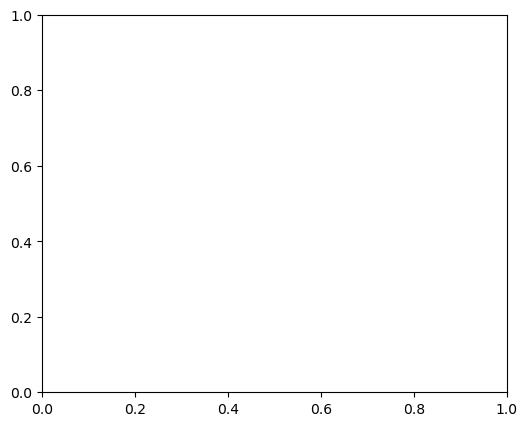

In [27]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 5), dpi=100)
axes.plot(muls,i_list,'.')

In [66]:
N_bus = 1000
N_node_eq = N_bus*2*4
1/N_node_eq*100

0.0125

In [28]:
json_file = 'cigre_europe_residential_4w2w.json'
json_file = json_file
json_data = open(json_file).read().replace("'",'"')
data = json.loads(json_data)
lines = data['lines']
line_codes = data['line_codes']

FileNotFoundError: [Errno 2] No such file or directory: 'cigre_europe_residential_4w2w.json'

In [29]:
svg_1 = svg('cigre.svg')


for line in lines:
    #if not 'monitor'in line or not 'vsc_line' in line: continue
    if 'monitor' in line:
        if not line['monitor']: continue
    if 'vsc_line' in line:
        if not line['vsc_line']: continue
    bus_j = line['bus_j']
    bus_k = line['bus_k']

    for ph in ['a','b','c','n']:

        I_max = data["line_codes"][line['code']]['I_max']
        i_r = grid_c0.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_r') 
        i_i = grid_c0.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_i') 
        i = i_r + 1j*i_i
        i_abs = np.abs(i)
        #print(f'l_{bus_j}_{bus_k}_{ph} = {i_abs:8.1f} A')
        if i_abs < 1e-3: continue
        i_sat = np.clip(i_abs/I_max*255,0,255)
        svg_1.set_color('line',f'l_{bus_j}_{bus_k}_{ph}',(int(i_sat),0,0))
        
        
#svg_1.set_color('rect','R1',(255,9,0))
svg_1.save('test_cigre.svg')
HTML('test_cigre.svg')

FileNotFoundError: [Errno 2] No such file or directory: 'cigre.svg'

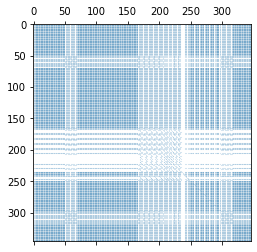

In [137]:
import matplotlib.pyplot as plt
import numpy as np

A = np.abs(grid_c0.P_slu.solve(np.eye(346)))
fig, axs = plt.subplots(1)
axs.spy(A, precision=1e-12, markersize=0.05)


In [53]:
grid_c0f = cigre_europe_residential_4w2w_dbf_class()
t_0 = time.time()
grid_c0f.ini({},'xy_0_dict.json')
print(time.time()-t_0)

0.0359039306640625


200.0

In [95]:
grid_c0f.ini({},'xy_0_dict.json')

grid_c0f.fill_factor_ini=10
grid_c0f.drop_tol_ini=0.001
grid_c0f.drop_rule_ini='interp'  # basic, prows, column, area, secondary, dynamic, interp. 


grid_c0f.lmax_it_ini=20
grid_c0f.ltol_ini=1e-6
grid_c0f.ldamp_ini=1

grid_c0f.eval_preconditioner_ini()




In [96]:
#%%timeit
t_0 = time.time()
p_R10 = np.random.rand()*10e3
grid_c0f.spini({'p_R10':p_R10},'xy_0_dict.json')
print(time.time()-t_0)
#print(grid_c0f.get_value('v_R10_a_r'))

0.01595759391784668


In [88]:
t_0 = time.time()
grid_c0f.ini({},'xy_0_dict.json')
print(time.time()-t_0)

0.05385541915893555


In [66]:
grid_c0f.mode = 0

In [21]:
%%timeit 
p_R10 = np.random.rand()*10e3
grid_c0f.ini({'p_R10':p_R10},'xy_0_dict.json')

44.6 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
grid_c0.P_slu.shape

(346, 346)

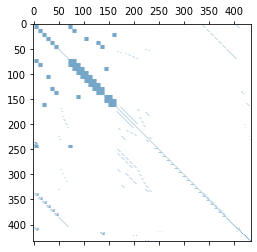

In [69]:
A = grid_c0f.jac_ini
fig, axs = plt.subplots(1)
axs.spy(A, precision=1e-8, markersize=0.05)


In [70]:
434*434

188356

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Fixing random state for reproducibility
np.random.seed(19680801)

fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

x = np.random.randn(20, 20)
x[5, :] = 0.
x[:, 12] = 0.

ax1.spy(x, markersize=5)
ax2.spy(x, precision=0.1, markersize=5)

ax3.spy(x)
ax4.spy(x, precision=0.1)

plt.show()

In [ ]:
plt.imshow(A[0:10,0:10], cmap='hot')
plt.show()

In [ ]:
A = grid_c0f.P_slu.solve(np.eye(434))
plt.imshow(np.abs(A), cmap='hot')
plt.show()

In [ ]:
self = grid_c0f
self.sp_jac_ini.data[self.sp_jac_ini.data==0]

In [7]:
p_R1 = 200e3
for ph in ['a','b','c']:
    grid_c0.set_value(f'p_R1_{ph}', -p_R1/3)
grid_c0.ss()

v_R18_a_r = grid_c0.get_value('v_R18_a_r')
v_R18_a_i = grid_c0.get_value('v_R18_a_i')
v_R18_a = v_R18_a_r + 1j*v_R18_a_i

In [138]:
def get_bus_powers(gt_grid,bus_name):
    idx = gt_grid.bus_data['bus_id'].index(bus_name)
    p_a,q_a = gt_grid.buses[idx]['p_a'],gt_grid.buses[idx]['p_a']
    p_b,q_b = gt_grid.buses[idx]['p_b'],gt_grid.buses[idx]['q_b']
    p_c,q_c = gt_grid.buses[idx]['p_c'],gt_grid.buses[idx]['q_c']
    p = p_a + p_b + p_c
    q = q_a + q_b + q_c
    return p,q

def vsc2params(vsc_losses,name,multiplier=1):
    i_rms  = np.array(vsc_losses[name]['i_rms'])
    p_loss = np.array(vsc_losses[name]['p_loss']) 
    c,b,a = np.polyfit(i_rms, p_loss*multiplier,2)
    return a,b,c

def report(grid, gt_grid):
    p_R0,q_R0 = get_bus_powers(gt_grid,'R0')
    p_R1,q_R1 = get_bus_powers(gt_grid,'R1')
    p_D1,q_D1 = get_bus_powers(gt_grid,'D1')
    p_R10,q_R10 = get_bus_powers(gt_grid,'R10')
    p_D10,q_D10 = get_bus_powers(gt_grid,'D10')
    p_R14,q_R14 = get_bus_powers(gt_grid,'R14')
    p_D14,q_D14 = get_bus_powers(gt_grid,'D14')

    p_R1_load = (loads_ac[0]['kVA']*np.exp(1j*np.arccos( loads_ac[0]['pf']))*1000).real

    p_main_vsc_ac = -(p_R1 - p_R1_load)

    p_dc_losses = p_main_vsc_ac - grid.p_dc_loads

    p_losses = p_R0 + grid.p_ac_loads + grid.p_dc_loads
    grid.p_losses = p_losses
    print(f'Grid power = {p_R0/1e3:0.2f} kW')
    print(f'AC loads   = {-grid.p_ac_loads/1e3:0.2f} kW')
    print(f'DC loads   = {-grid.p_dc_loads/1e3:0.2f} kW')
    print(f'Total load = {-(grid.p_ac_loads+grid.p_dc_loads)/1e3:0.2f} kW')
    p_loss_R1  = -(p_R1+p_D1-p_R1_load)
    p_loss_R10 = -(p_R10+p_D10)
    p_loss_R14 = -(p_R14+p_D14)
    print(f'VSC Losses: R1 = {p_loss_R1:0.2f} W ({-p_loss_R1/p_R1*100:0.1f}%),  R10 = {p_loss_R10:0.2f} W ({p_loss_R10/p_R10*100:0.1f}%),  R14 = {p_loss_R14:0.2f} W ({p_loss_R14/p_R14*100:0.1f}%)')

    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('R1', 'R2'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current R1-R2 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('R4', 'R12'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current R4-R12 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('D1', 'D3'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current D1-D3 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('D4', 'D14'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current D4-R14 ={i_j_a_m:0.2f} A')


### VSC models

In [139]:
vsc_losses = {
    'vsc_3ph3w_200A_100kVA':{'model':'','coolant':'air','v_dc':800,
                            'i_rms':[50,100,200],'p_loss':[404.9,871.61,2090.05],'rend':[98.6,98.54,98.26]},
    'vsc_3ph3w_250A_200kVA':{'model':'SKiiP1213GB123-2DW V3','coolant':'water','Rth_sa': 0.0114,'v_dc':800,
                            'i_rms':[125,250,500],'p_loss':[1210.95,2610.23,6229.22],'rend':[98.38,98.26,97.93]}, 
    'vsc_1ph2w_120A':{'model':'SKiiP39AC12T7V1_HpTp','coolant':'air','v_dc':800,'pf':0.85,'Rth_sa': 0.0707,
                         'i_rms':[20,40,60,80,100,120],
                         'p_loss':[96.91,205.54,322.16,455.22,609.84,795.07],
                         'rend':[97.59,97.45,97.34,97.18,96.99,96.74]}
}



## Case 0

In [140]:
loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": 0.0},
           {"bus": "D15", "kW": 0.0},
           {"bus": "D16", "kW": 0.0},
           {"bus": "D17", "kW": 0.0},
           {"bus": "D18", "kW": 0.0}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_200A_100kVA')},
       {"bus": "R10","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_200A_100kVA')},
       {"bus": "R14","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_200A_100kVA')}
      ]

In [141]:
grid_c0 = cigre_europe_residential_4w2w_class()

grid_c0.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c0,bus_name,s)
    grid_c0.p_ac_loads += s.real

grid_c0.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c0.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c0.set_value(f'q_{bus_name}_1',0.0)
       
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c0.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c0.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c0.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c0.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c0.set_value(f'c_{bus_name}',vsc['losses'][2])
    

import json 

def save_params(self,file_name = 'case_0_parameters.json'):
    params_dict = {}
    for item in self.params_list:
        params_dict.update({item:self.get_value(item)})

    params_dict_str = json.dumps(params_dict, indent=4)
    with open(file_name,'w') as fobj:
        fobj.write(params_dict_str)

def save_inputs_ini(self,file_name = 'case_0_inputs_ini.json'):
    inputs_ini_dict = {}
    for item in self.inputs_ini_list:
        inputs_ini_dict.update({item:self.get_value(item)})

    inputs_ini_dict_str = json.dumps(inputs_ini_dict, indent=4)
    with open(file_name,'w') as fobj:
        fobj.write(inputs_ini_dict_str)
              
def load_inputs_ini(self,data_input):

    if type(data_input) == str:
        json_file = data_input
        self.json_file = json_file
        self.json_data = open(json_file).read().replace("'",'"')
        data = json.loads(self.json_data)
    elif type(data_input) == dict:
        data = data_input

    for item in data:
        self.struct[0][item] = data[item]
        self.inputs_ini_values_list[self.inputs_ini_list.index(item)] = data[item]
        self.set_value(item,data[item])
            
            
save_params(grid_c0)
save_inputs_ini(grid_c0)


In [143]:
grid_c0.load_params('case_0_parameters.json')
grid_c0.load_params('case_0_inputs_ini.json')
grid_c0.ini({},'xy_0_dict.json')
gt_grid = gt.grid(grid_c0)

AttributeError: 'cigre_europe_residential_4w2w_class' object has no attribute 'struct'

In [59]:
gt_grid = gt.grid(grid_c0)
gt_grid.dae2vi()

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='1003', ...)

In [14]:
def s_eval(grid,bus_j,bus_k):
    line_id = f'{bus_j}_{bus_k}'
    i_t_r = np.array(grid.get_mvalue([f'i_t_{line_id}_a_r',f'i_t_{line_id}_b_r',f'i_t_{line_id}_c_r']))
    i_t_i = np.array(grid.get_mvalue([f'i_t_{line_id}_a_i',f'i_t_{line_id}_b_i',f'i_t_{line_id}_c_i']))
    i_t = i_t_r + 1j*i_t_i
    v_r = np.array(grid.get_mvalue([f'v_{bus_j}_a_r',f'v_{bus_j}_b_r',f'v_{bus_j}_c_r']))
    v_i = np.array(grid.get_mvalue([f'v_{bus_j}_a_i',f'v_{bus_j}_b_i',f'v_{bus_j}_c_i']))
    v = v_r + 1j*v_i
    
    s = v.T @ np.conj(i_t)
    return s


In [15]:
grid = grid_c0
grid.initialization_tol = 1e-8
def obj_eval(x):

    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    s_t = s_eval(grid,'R0','R1')
    p_head = float(s_t.real)
    #print(f'p_loss = {p_loss/1e3:0.2f}')

    return p_head



In [16]:
sol = sopt.minimize(obj_eval,[10e3]*4,method='Powell',bounds=[(-50e3,50e3)]*4) # SLSQP, Powell
sol

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.05619837e+03, -4.40626705e+02,  3.10373770e+02,
         9.30591158e+01]])
     fun: array(394154.46549016)
 message: 'Optimization terminated successfully.'
    nfev: 282
     nit: 3
  status: 0
 success: True
       x: array([40719.61622939, 29828.3615968 , 35709.0174598 , 18348.42156993])

In [17]:
def contraint_I_R1_R2(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_R1_R2 = np.abs(grid_c0.get_value('i_l_R1_R2_a_r')+1j*grid_c0.get_value('i_l_R1_R2_a_i'))
    return I_R1_R2

def contraint_I_VSC_R1(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_VSC_R1 = np.abs(grid_c0.get_value('i_vsc_R1_a_r')+1j*grid_c0.get_value('i_vsc_R1_a_i'))
    return I_VSC_R1

def contraint_I_VSC_R10(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_VSC_R10 = np.abs(grid_c0.get_value('i_vsc_R10_a_r')+1j*grid_c0.get_value('i_vsc_R10_a_i'))
    return I_VSC_R10

def contraint_I_VSC_R14(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_VSC_R14 = np.abs(grid_c0.get_value('i_vsc_R14_a_r')+1j*grid_c0.get_value('i_vsc_R14_a_i'))
    return I_VSC_R14


nlcs = (
    NonlinearConstraint(contraint_I_R1_R2, -np.inf, 160),
    NonlinearConstraint(contraint_I_VSC_R1, -np.inf, 160),
    NonlinearConstraint(contraint_I_VSC_R10, -np.inf, 20),
    NonlinearConstraint(contraint_I_VSC_R14, -np.inf, 30),
    
)

sopt.differential_evolution(obj_eval, bounds=[(-50e3,50e3)]*4,constraints=(nlcs), tol=1e-10)

NameError: name 'NonlinearConstraint' is not defined

In [ ]:
           constr: [array([0.])]
 constr_violation: 0.0
              fun: 394250.2397244236
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 5090
              nit: 162
          success: True
                x: array([48825.59389023, 32058.74316143, 40651.51398465, 19213.75435129])

In [109]:
I_VSC_R1 = np.abs(grid_c0.get_value('i_vsc_R1_a_r')+1j*grid_c0.get_value('i_vsc_R1_a_i'))
I_VSC_R1

128.84763241935278

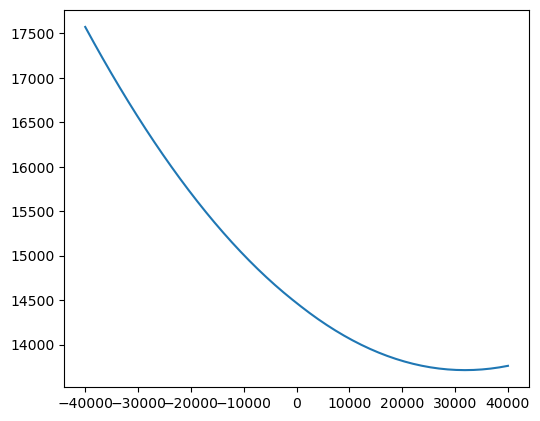

In [65]:
p_loss_1 = []
p_loss_2 = []
qs_1 = np.linspace(-40e3,40e3)
for q in qs_1:
    p_loss_1 += [obj_eval(np.array([0,0,0,q]))]
    p_loss_2 += [obj_eval(np.array([40e3,q,40e3,0]))]
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 5), dpi=100)

axes.plot(qs_1,p_loss_1)
#axes.plot(qs_1,p_loss_2)

In [117]:
gt_grid = gt.grid(grid)
gt_grid.dae2vi()

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='2803', ...)

## Case 1

In [9]:
scale = 1.5
loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": 0.0},
           {"bus": "D15", "kW": 0.0},
           {"bus": "D16", "kW": 0.0},
           {"bus": "D17", "kW": 0.0},
           {"bus": "D18", "kW": 0.0}]

vscs =[{"bus":  "R10", "kW":0.0, "kvar": 0.0},
        {"bus": "R14", "kW":0.0, "kvar": 0.0}]

In [10]:
grid_c1 = cigre_europe_residential_acdc_class()
grid_c1.initialization_tol = 1e-8

for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c1,bus_name,s)

for load in loads_dc:
    bus_name = load['bus']
    grid_c1.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c1.set_value(f'q_{bus_name}_1',0.0)
    
for vsc in vscs:
    bus_name = load['bus']
    s = vsc['kW'] + 1j*vsc['kvar']
    grid_c1.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
    grid_c1.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)


grid_c1.initialize([{}],xy0='xy_0_dict.json',compile=True)
gt_grid = gt.grid(grid_c1)


NameError: name 'cigre_europe_residential_acdc_class' is not defined

In [106]:
gt_grid.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid.I_node[idx] += grid_c1.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid_c1.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

NameError: name 'grid_c1' is not defined

## Case 2

In [96]:
scale_ac = 1.0
scale_dc = 0.5

loads_ac =[{"bus":  "R1", "kVA":-00.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale_ac, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale_ac, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale_ac, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale_ac, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale_ac, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": -15.0*scale_dc},
           {"bus": "D15", "kW": -52.0*scale_dc},
           {"bus": "D16", "kW": -55.0*scale_dc},
           {"bus": "D17", "kW": -35.0*scale_dc},
           {"bus": "D18", "kW": -47.0*scale_dc}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')},
       {"bus": "R10","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')},
       {"bus": "R14","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')}
      ]


In [97]:
grid_c2 = cigre_europe_residential_4w2w_class()
grid_c2.initialization_tol = 1e-8

grid_c2.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c2,bus_name,s)
    grid_c2.p_ac_loads += s.real

grid_c2.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c2.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c2.set_value(f'q_{bus_name}_1',0.0)
    grid_c2.p_dc_loads += load['kW']*1000.0
    
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c2.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c2.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c2.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c2.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c2.set_value(f'c_{bus_name}',vsc['losses'][2])
    
grid_c2.initialize([{}],xy0='xy_0_dict.json',compile=True)
gt_grid_c2 = gt.grid(grid_c2)


In [98]:
gt_grid_c2.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid_c2.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        I_r = grid_c2.get_value(f'i_vsc_{vsc_bus}_{ph}_r')
        I_i = grid_c2.get_value(f'i_vsc_{vsc_bus}_{ph}_i')
        gt_grid_c2.I_node[idx] += I_r+1j*I_i

gt_grid_c2.get_v()
gt_grid_c2.get_i()

gt_grid_c2.bokeh_tools()

gt.plot_results(gt_grid_c2)



Figure(id='1863', ...)

In [99]:
report(grid_c2, gt_grid_c2)

Grid power = 311.44 kW
AC loads   = 193.80 kW
DC loads   = 102.00 kW
Total load = 295.80 kW
VSC Losses: R1 = 106404.72 W (50.7%),  R10 = 87.65 W (665137773198266271525010581409567854297088.0%),  R14 = 87.65 W (2461545763729826353443264930983662265040896.0%)
Current R1-R2 =317.52 A
Current R4-R12 =81.94 A
Current D1-D3 =129.19 A
Current D4-R14 =32.92 A


In [100]:
grid_c2.report_params()

a_R1  = 85.15
b_R1  =  7.91
c_R1  =  0.01
a_R10 = 85.15
b_R10 =  7.91
c_R10 =  0.01
coef_a_R10 =  0.33
coef_b_R10 =  0.33
coef_c_R10 =  0.33
a_R14 = 85.15
b_R14 =  7.91
c_R14 =  0.01
coef_a_R14 =  0.33
coef_b_R14 =  0.33
coef_c_R14 =  0.33


## Case 3

In [8]:
scale_ac = 0.1
scale_dc = 1.0

loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale_ac, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale_ac, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale_ac, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale_ac, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale_ac, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": -15.0*scale_dc},
           {"bus": "D15", "kW": -52.0*scale_dc},
           {"bus": "D16", "kW": -55.0*scale_dc},
           {"bus": "D17", "kW": -35.0*scale_dc},
           {"bus": "D18", "kW": -47.0*scale_dc}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA',multiplier=1)},
       {"bus": "R10","type":'pq', "kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_1ph2w_120A')},
       {"bus": "R14","type":'pq', "kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_1ph2w_120A')}
      ]


In [9]:
grid_c3 = cigre_europe_residential_2w2w_class()
grid_c3.initialization_tol = 1e-12

grid_c3.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    if bus_name == 'R1':
        s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
        gt.set_powers(grid_c3,bus_name,s)
        grid_c3.p_ac_loads += s.real
    if bus_name != 'R1':
        s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
        grid_c3.set_value(f'p_{bus_name}_a',s.real)
        grid_c3.set_value(f'p_{bus_name}_b',0.0)
        grid_c3.set_value(f'p_{bus_name}_c',0.0)
        grid_c3.set_value(f'q_{bus_name}_a',s.imag)
        grid_c3.set_value(f'q_{bus_name}_b',0.0)
        grid_c3.set_value(f'q_{bus_name}_c',0.0)
        grid_c3.p_ac_loads += s.real
    
grid_c3.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c3.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c3.set_value(f'q_{bus_name}_1',0.0)
    grid_c3.p_dc_loads += load['kW']*1000.0
    
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c3.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c3.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c3.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c3.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c3.set_value(f'c_{bus_name}',vsc['losses'][2])

solx = np.array([ 31725.12992576,  37213.72959454,  31933.80290348, -36446.6370987 ])
solx = np.array([28421.96223811, 15531.3515862 , 23105.72335649,  9431.03994459])
#grid_c3.initialize([{'p_R10':solx[0],'q_R10':solx[1],'coef_a_R10':1.0,'coef_b_R10':0.0,'coef_c_R10':0.0,
#                     'p_R14':solx[2],'q_R14':solx[3],'coef_a_R14':1.0,'coef_b_R14':0.0,'coef_c_R14':0.0}],
#                     xy0='xy_0_dict.json',compile=True)
grid_c3.load_0('xy_0_dict.json')
grid_c3.ss()

In [10]:
gt_grid_c3 = gt.grid(grid_c3)

gt_grid_c3.dae2vi()

gt_grid_c3.get_v()
gt_grid_c3.get_i()

gt_grid_c3.bokeh_tools()

gt.plot_results(gt_grid_c3)

Figure(id='1145', ...)

In [11]:
grid = grid_c3
grid.initialization_tol = 1e-8
def obj_eval(x):
    p_R10 = x[0]
    q_R10 = x[1]
    p_R14 = x[2]
    q_R14 = x[3]
    #
    grid.set_value('p_R10', p_R10)
    grid.set_value('p_R14', p_R14)
    grid.set_value('q_R10', q_R10)
    grid.set_value('q_R14', q_R14)
    
    grid.ss()

    bus_from,bus_to = 'R0','R1'
    i_t_r_list = []
    i_t_i_list = []
    for ph in ['a','b','c']:
        i_t_r_list += [f'i_t_{bus_from}_{bus_to}_{ph}_r']
        i_t_i_list += [f'i_t_{bus_from}_{bus_to}_{ph}_i']
    i_t = np.array(grid.get_mvalue(i_t_r_list)) +1j*np.array(grid.get_mvalue(i_t_i_list))

    v_t = gt.get_voltage(grid,bus_from,output='v_abcn')

    s_t = v_t.T @ np.conj(i_t).reshape(3,1)
    p_loss = float(s_t.real+grid_c3.p_ac_loads+grid_c3.p_dc_loads)
    #print(f'p_loss = {p_loss/1e3:0.2f}')

    return p_loss


In [26]:
sol = sopt.minimize(obj_eval,[10e3]*4,method='Powell',bounds=[(-50e3,50e3)]*4) # SLSQP, Powell
sol

   direc: array([[   0.        ,    0.        ,    0.        ,    1.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    1.        ,    0.        ],
       [-297.41706976,  -31.8052777 ,   57.16811962,   10.44169443]])
     fun: array(25377.29323184)
 message: 'Optimization terminated successfully.'
    nfev: 262
     nit: 3
  status: 0
 success: True
       x: array([28421.94957707, 15531.61331538, 23105.72994969,  9430.9358909 ])

In [27]:
gt_grid_c3 = gt.grid(grid_c3)

gt_grid_c3.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid_c3.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid_c3.I_node[idx] += grid_c3.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid_c3.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid_c3.get_v()
gt_grid_c3.get_i()

gt_grid_c3.bokeh_tools()

gt.plot_results(gt_grid_c3)

Figure(id='1145', ...)

In [82]:
def ini_problem(self,x):
    self.struct[0].x[:,0] = x[0:self.N_x]
    self.struct[0].y_ini[:,0] = x[self.N_x:(self.N_x+self.N_y)]
    if self.compile:
       # ini(self.struct,2)
        ini(self.struct,3)       
    else:
        ini.py_func(self.struct,2)
        ini.py_func(self.struct,3)                   
    fg = np.vstack((self.struct[0].f,self.struct[0].g))[:,0]
    return fg

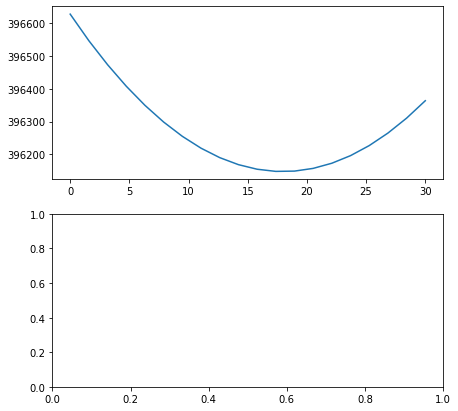

In [55]:
fig,  axes   = plt.subplots(nrows=2,ncols=1, figsize=(7, 7))
axes[0].plot(p_dc/1e3,p_loss)

In [17]:
sol

   direc: array([[   0.        ,    1.        ],
       [-935.21979958,  339.14541993]])
     fun: array(12282.76966481)
 message: 'Optimization terminated successfully.'
    nfev: 116
     nit: 3
  status: 0
 success: True
       x: array([20871.11509636, 23407.62236097])

In [21]:
gt_grid.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid.I_node[idx] += grid.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='1145', ...)

In [39]:
from importlib import reload  



In [40]:
reload(ini)

TypeError: reload() argument must be a module

In [31]:
ini(grid_c3.struct,1)

In [148]:
@numba.njit(cache=True)
def ssate(struct,xy):
    for it in range(100):
        ini_dae_jacobian_numba(struct,xy[:,0])
        ini_dae_problem(struct,xy[:,0])
        xy[:] += np.linalg.solve(struct[0].Ac_ini,-struct[0].fg)
        if np.max(np.abs(struct[0].fg[:,0]))<1e-8: break
    N_x = struct[0].N_x
    struct[0].x[:,0] = xy[:N_x,0]
    struct[0].y_ini[:,0] = xy[N_x:,0]
    return xy,it

In [6]:
305.5-212.5

93.0

In [1]:
from scipy.optimize import rosen, differential_evolution
bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]


In [8]:
%timeit result = differential_evolution(rosen, bounds)
result.x, result.fun

3.38 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'result' is not defined

In [7]:
%timeit result = differential_evolution(rosen, bounds, updating='deferred', workers=2)
result.x, result.fun

6.26 s ± 950 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'result' is not defined

In [9]:
from multiprocessing import Process
import os

def info(title):
    print(title)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())

def f(name):
    info('function f')
    print('hello', name)

if __name__ == '__main__':
    info('main line')
    p = Process(target=f, args=('bob',))
    p.start()
    p.join()

main line
module name: __main__
parent process: 5780
process id: 6040


In [3]:
import multiprocessing as mp
import time 
from scipy.optimize import rosen, differential_evolution

rosen_1 = rosen
rosen_2 = rosen
pool = mp.Pool(4)  # existing worker pool

bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]

t_0 = time.time()
result = differential_evolution(rosen, bounds, updating='deferred', workers=pool.map)
print(time.time() - t_0)
result

6.6938416957855225


     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48006
     nit: 639
 success: True
       x: array([1., 1., 1., 1., 1.])

In [4]:
rosen_1 = rosen
rosen_2 = rosen
pool.Map([rosen_1,rosen_2])

AttributeError: 'Pool' object has no attribute 'Map'